In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 检查GPU是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# 数据预处理和加载
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 定义编码器
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        # 定义解码器
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 实例化模型并移动到GPU
model = Autoencoder().to(device)

In [7]:
# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 3
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)  # 将图像展平成一维向量

        # 前向传播
        output = model(img)
        loss = criterion(output, img)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/3], Loss: 0.1517
Epoch [2/3], Loss: 0.1462
Epoch [3/3], Loss: 0.1019


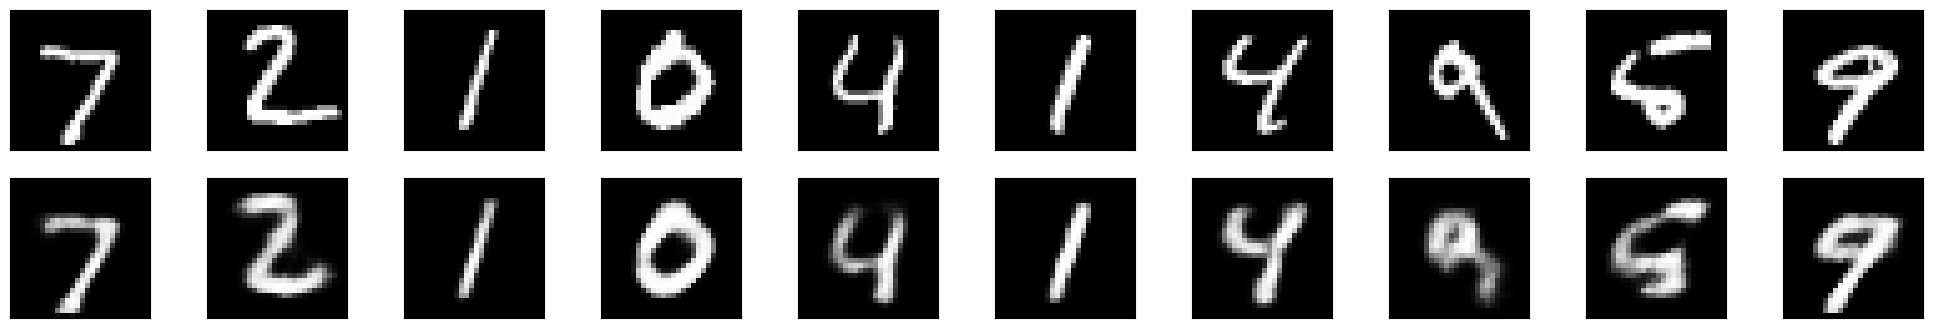

In [9]:
import matplotlib.pyplot as plt

# 加载测试数据集
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

# 获取一些测试数据
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.view(images.size(0), -1).to(device)

# 使用自编码器重构图像
outputs = model(images)

# 可视化原始图像和重构图像
outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
images = images.view(images.size(0), 1, 28, 28).cpu().data

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, outputs], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.numpy().squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()

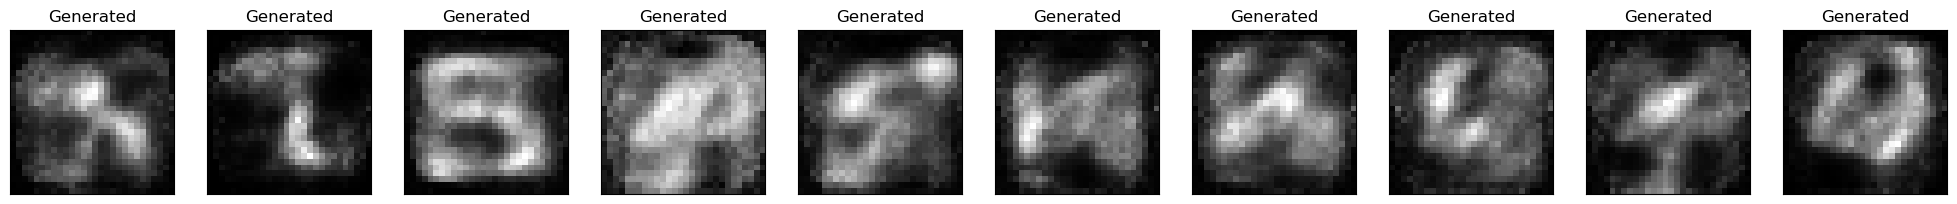

In [10]:
# 从潜在空间中抽取随机向量，生成新图像
num_samples = 10
random_latent_vectors = torch.randn(num_samples, 32).to(device)  # 抽取随机向量
generated_images = model.decoder(random_latent_vectors)

# 将生成结果从GPU移动到CPU，并调整维度以便可视化
generated_images = generated_images.view(num_samples, 1, 28, 28).cpu().data

# 可视化生成的新图像
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for i in range(10):
    axes[i].imshow(generated_images[i].numpy().squeeze(), cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_title("Generated")

plt.show()